# ModVege grass growth model (Jouven et al. 2006) with EURO-CORDEX data

- Jouven, M., Carrère, P., and Baumont, R. (2006a). 'Model predicting
  dynamics of biomass, structure and digestibility of herbage in managed
  permanent pastures. 1. Model description', *Grass and Forage Science*,
  vol. 61, no. 2, pp. 112-124. DOI:
  [10.1111/j.1365-2494.2006.00515.x][Jouven1].
- Jouven, M., Carrère, P., and Baumont, R. (2006b). 'Model predicting
  dynamics of biomass, structure and digestibility of herbage in managed
  permanent pastures. 2. Model evaluation', *Grass and Forage Science*,
  vol. 61, no. 2, pp. 125-133. DOI:
  [10.1111/j.1365-2494.2006.00517.x][Jouven2].
- Chemin, Y. (2022). 'modvege', Python. [Online]. Available at
  <https://github.com/YannChemin/modvege> (Accessed 6 September 2022).

[Jouven1]: https://doi.org/10.1111/j.1365-2494.2006.00515.x
[Jouven2]: https://doi.org/10.1111/j.1365-2494.2006.00517.x

In [1]:
import glob
import os
from datetime import datetime, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import Client
import climag.plot_configs as cplt

In [2]:
print("Last updated:", datetime.now(tz=timezone.utc))

Last updated: 2023-04-11 13:49:52.052799+00:00


In [4]:
client = Client(n_workers=2, threads_per_worker=4, memory_limit="3GB")

2023-03-30 00:38:42,197 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-newvwy4m', purging
2023-03-30 00:38:42,197 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-o3f6fa64', purging


In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 5.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34761,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 5.59 GiB
Comm: tcp://127.0.0.1:38829,Total threads: 4
Dashboard: http://127.0.0.1:45733/status,Memory: 2.79 GiB
Nanny: tcp://127.0.0.1:38305,


In [3]:
DATA_DIR = os.path.join("data", "ModVege")

In [4]:
# Ireland boundary
GPKG_BOUNDARY = os.path.join("data", "boundaries", "boundaries_all.gpkg")
ie = gpd.read_file(GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE")
ie_bbox = gpd.read_file(
    GPKG_BOUNDARY, layer="NUTS_RG_01M_2021_2157_IE_BBOX_DIFF"
)

In [5]:
# met station coords
LON, LAT = -8.26389, 52.16389  # Moorepark, Fermoy

## Historical data

In [6]:
data = xr.open_mfdataset(
    glob.glob(
        os.path.join(DATA_DIR, "EURO-CORDEX", "historical", "EC-EARTH", "*.nc")
    ),
    chunks="auto",
    decode_coords="all",
)

In [7]:
data

<xarray.Dataset>
Dimensions:       (rlat: 33, rlon: 37, time: 11323, bnds: 2)
Coordinates:
    lat           (rlat, rlon) float64 dask.array<chunksize=(33, 37), meta=np.ndarray>
    lon           (rlat, rlon) float64 dask.array<chunksize=(33, 37), meta=np.ndarray>
  * rlat          (rlat) float64 3.685 3.795 3.905 4.015 ... 6.985 7.095 7.205
  * rlon          (rlon) float64 -17.27 -17.16 -17.05 ... -13.53 -13.41 -13.3
  * time          (time) datetime64[ns] 1975-01-01T12:00:00 ... 2005-12-31T12...
    height        float64 2.0
    rotated_pole  |S1 b''
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    spatial_ref   int64 0
Dimensions without coordinates: bnds
Data variables: (12/24)
    bm_gv         (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    bm_gr         (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    bm_dv         (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    bm_dr         (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    age_gv        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    age_gr        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    ...            ...
    sen_gv        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    sen_gr        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    abs_dv        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    abs_dr        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    omd_gv        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
    omd_gr        (time, rlat, rlon) float32 dask.array<chunksize=(365, 33, 37), meta=np.ndarray>
Attributes:
    creation_date:  2023-03-11 00:16:37.316077+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_EURO-CORDEX_RCA4_EC-EARTH_historical

In [8]:
# remove the spin-up year
data = data.sel(time=slice("1976", "2005"))

### Seasonal averages

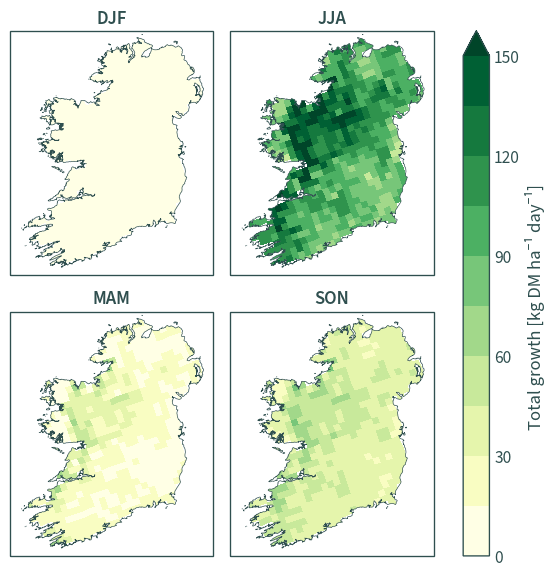

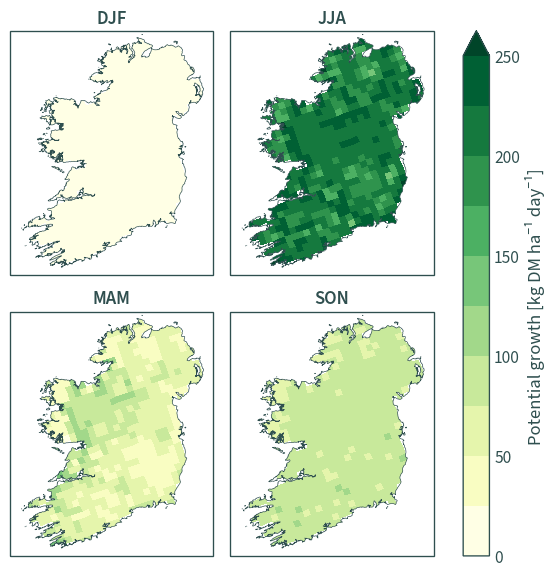

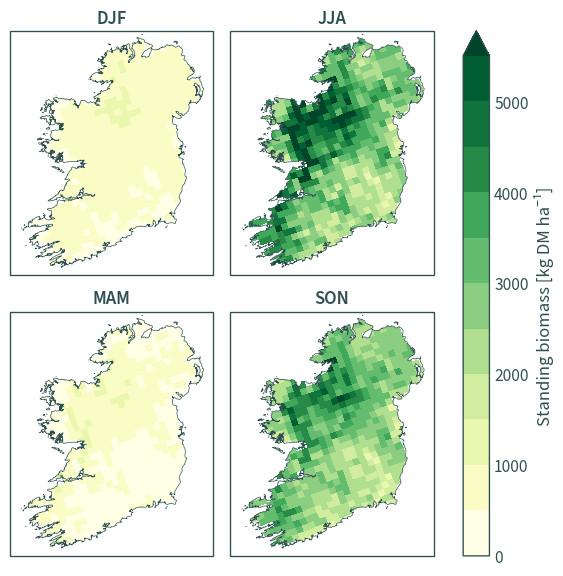

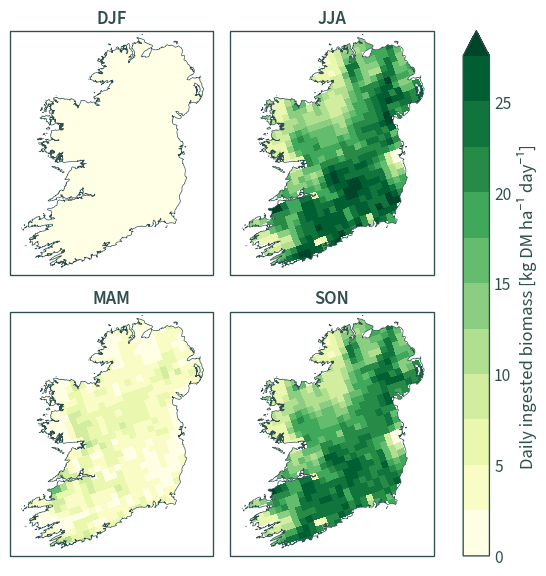

In [14]:
for var in ["gro", "pgro", "bm", "c_bm"]:
    cplt.plot_averages(
        data=data,
        var=var,
        averages="season",
        boundary_data=ie_bbox,
        cbar_levels=12,
    )

### Point subset

In [10]:
cds = cplt.rotated_pole_point(data=data, lon=LON, lat=LAT)

In [11]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest")

In [12]:
data_ie

<xarray.Dataset>
Dimensions:       (time: 11323, bnds: 2)
Coordinates:
    lat           float64 dask.array<chunksize=(), meta=np.ndarray>
    lon           float64 dask.array<chunksize=(), meta=np.ndarray>
    rlat          float64 4.235
    rlon          float64 -15.83
  * time          (time) datetime64[ns] 1975-01-01T12:00:00 ... 2005-12-31T12...
    height        float64 2.0
    rotated_pole  |S1 b''
    time_bnds     (time, bnds) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    spatial_ref   int64 0
Dimensions without coordinates: bnds
Data variables: (12/24)
    bm_gv         (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    bm_gr         (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    bm_dv         (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    bm_dr         (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    age_gv        (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    age_gr        (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    ...            ...
    sen_gv        (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    sen_gr        (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    abs_dv        (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    abs_dr        (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    omd_gv        (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
    omd_gr        (time) float32 dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    creation_date:  2023-03-11 00:16:37.316077+00:00
    contact:        nstreethran@ucc.ie
    frequency:      day
    references:     https://github.com/ClimAg
    input_dataset:  IE_EURO-CORDEX_RCA4_EC-EARTH_historical

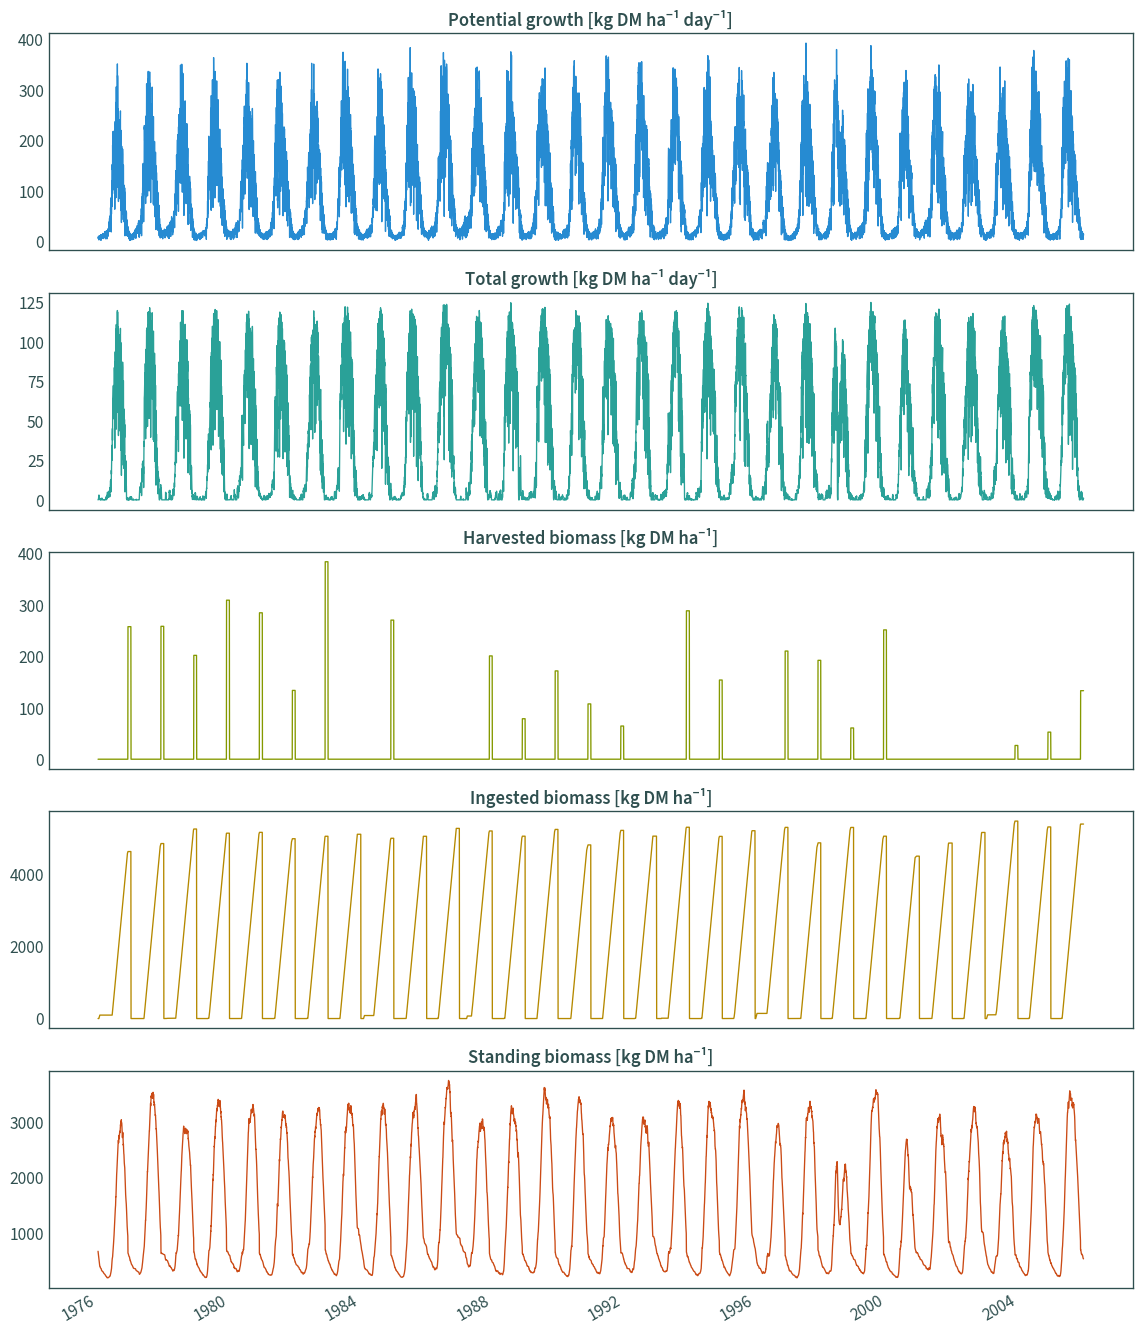

In [16]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest")

data_ie_df = pd.DataFrame({"time": data_ie["time"]})
for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]

data_ie_df.set_index("time", inplace=True)
data_ie_df = data_ie_df[["pgro", "gro", "h_bm", "i_bm", "bm"]]

# configure plot title
plot_title = []
for var in list(data_ie_df):
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.plot(
    subplots=True,
    layout=(5, 1),
    figsize=(12, 14),
    legend=False,
    xlabel="",
    title=plot_title,
    linewidth=1,
)

plt.tight_layout()
plt.show()

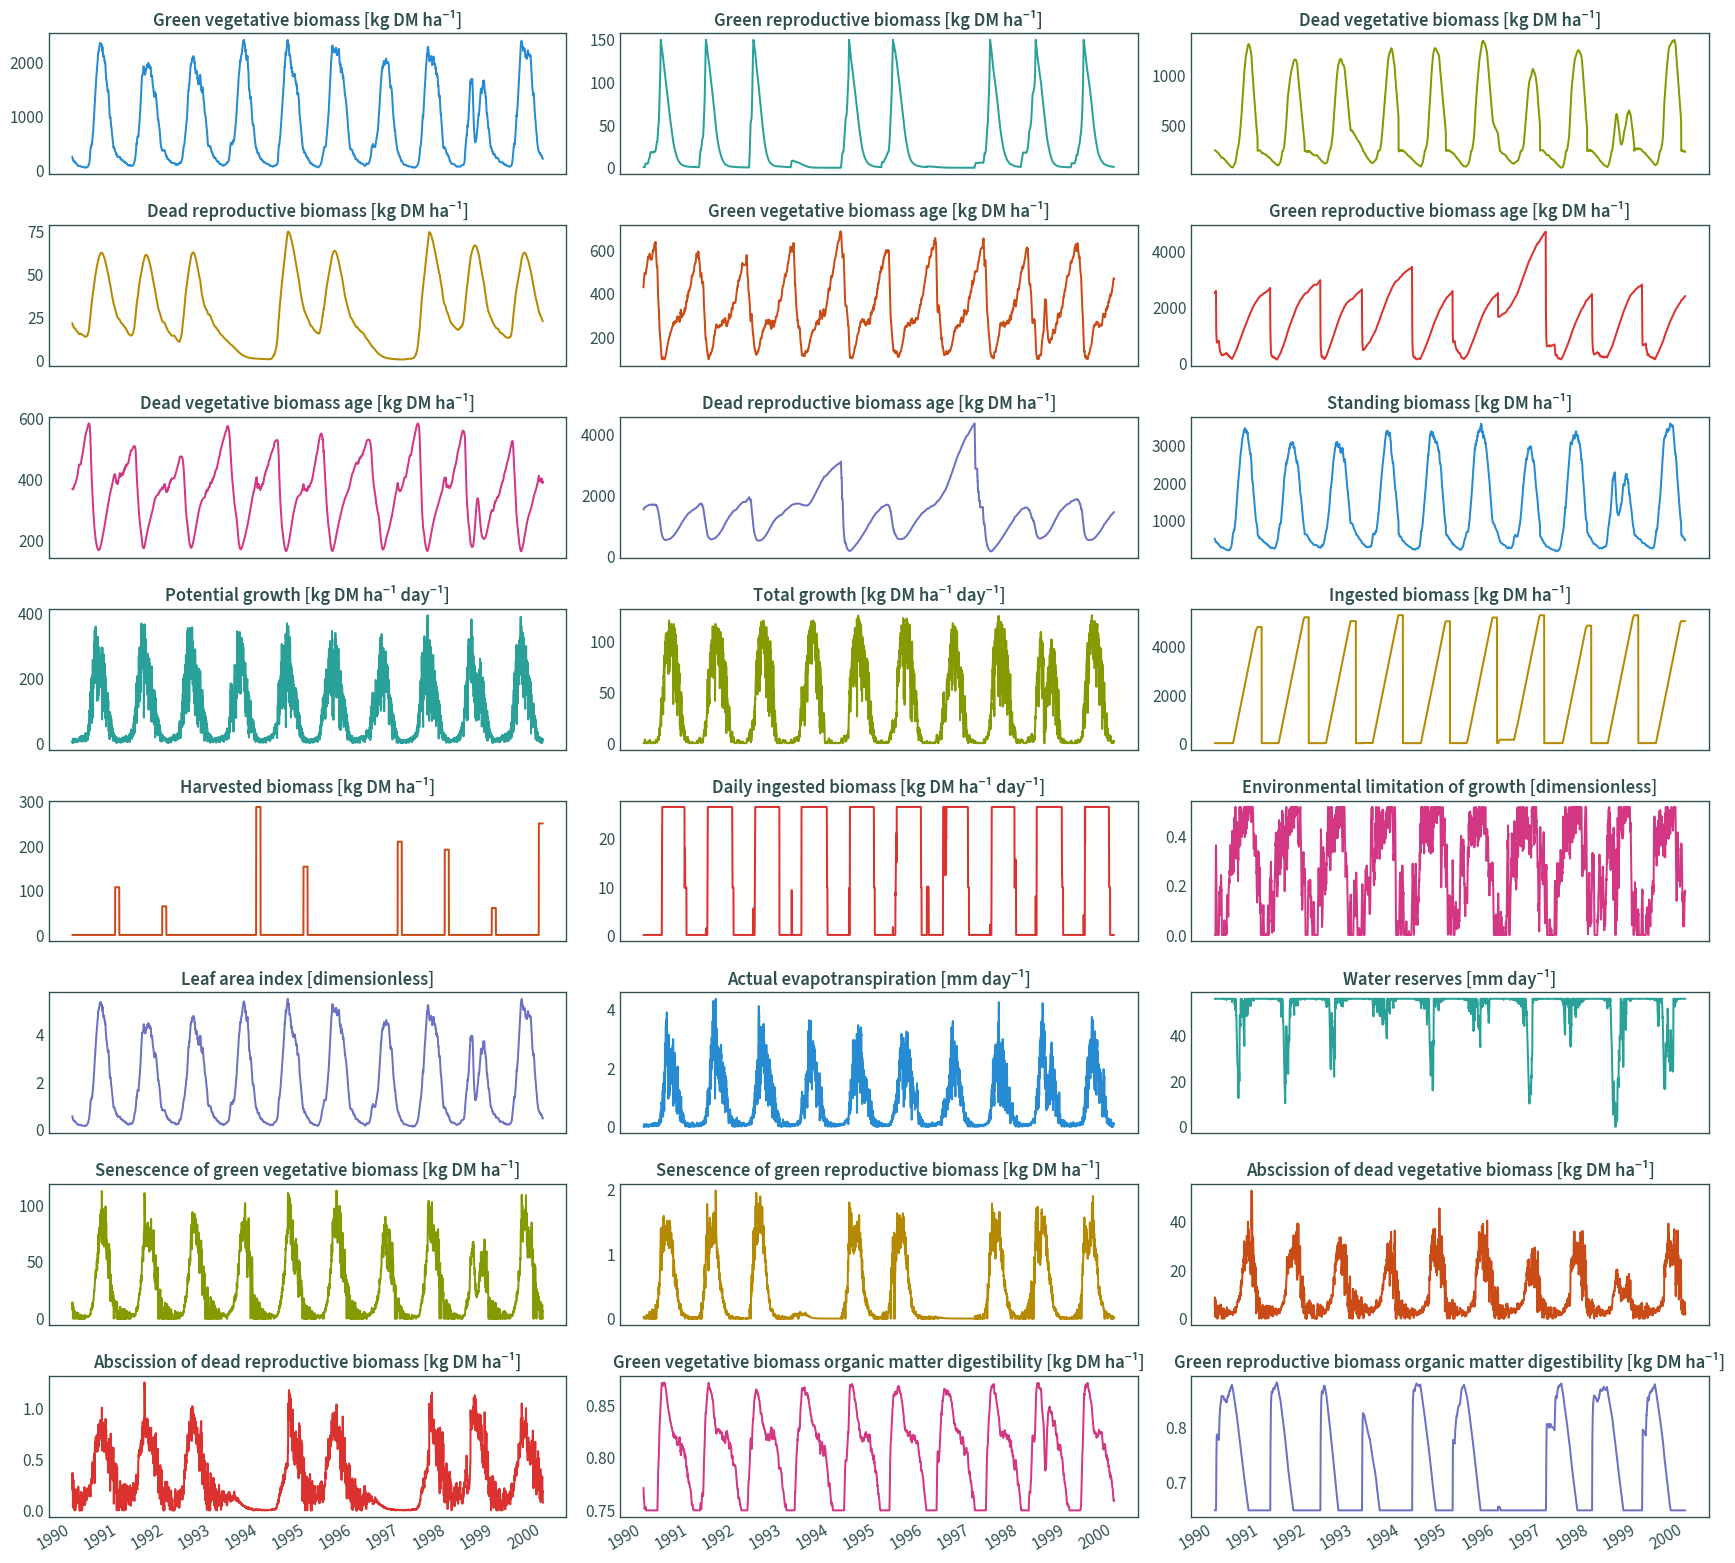

In [22]:
data_ie = data.sel({"rlon": cds[0], "rlat": cds[1]}, method="nearest").sel(
    time=slice("1990", "1999")
)

data_ie_df = pd.DataFrame({"time": data_ie["time"]})

# configure plot title
plot_title = []

for var in data_ie.data_vars:
    data_ie_df[var] = data_ie[var]
    plot_title.append(
        f"{data_ie[var].attrs['long_name']} [{data_ie[var].attrs['units']}]"
    )

data_ie_df.set_index("time", inplace=True)

data_ie_df.plot(
    subplots=True,
    layout=(9, 3),
    figsize=(18, 18),
    legend=False,
    xlabel="",
    title=plot_title,
    linewidth=1,
)

plt.tight_layout()
plt.show()

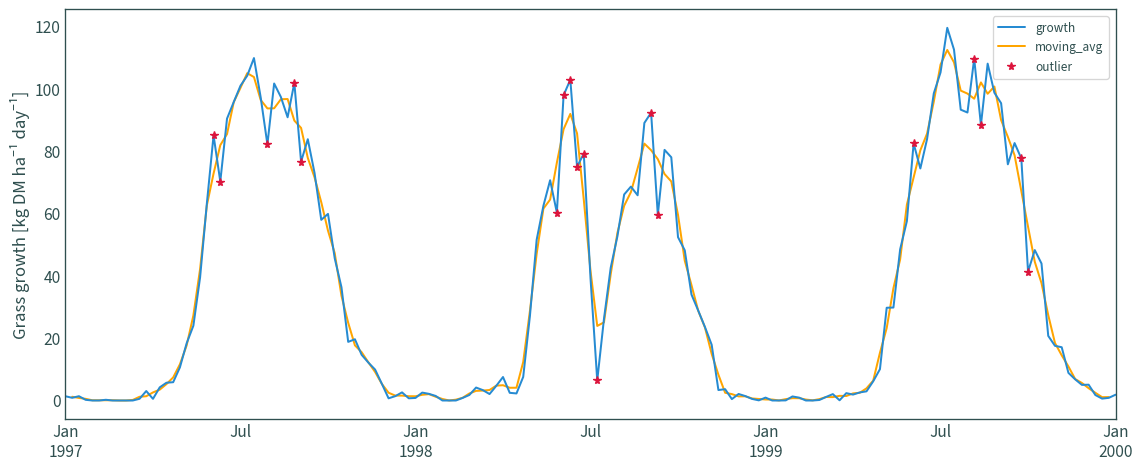

In [23]:
data_ie_y = data_ie.sel(time=slice("1997", "1999"))

data_ie_df = pd.DataFrame({"time": data_ie_y["time"]})

for var in data_ie_y.data_vars:
    data_ie_df[var] = data_ie_y[var]

data_ie_df.set_index("time", inplace=True)
data_ie_df = data_ie_df[["gro"]]

# resample to weekly
data_ie_df = data_ie_df.resample("W-MON").mean()

data_ie_df.reset_index(inplace=True)
mn = data_ie_df.rolling(3, center=True, on="time")["gro"].mean()
data_ie_df["outlier"] = data_ie_df["gro"].sub(mn).abs().gt(10)
data_ie_df["moving_avg"] = mn
data_ie_df.set_index("time", inplace=True)

axs = data_ie_df.plot(y="gro", figsize=(12, 5), xlabel="", label="growth")
data_ie_df.plot(y="moving_avg", ax=axs, color="orange", zorder=1)
if True in list(data_ie_df["outlier"].unique()):
    data_ie_df[data_ie_df["outlier"] == True].plot(
        y="gro",
        ax=axs,
        marker="*",
        linewidth=0,
        color="crimson",
        label="outlier",
    )
plt.xlabel("")
plt.ylabel("Grass growth [kg DM ha⁻¹ day⁻¹]")
plt.tight_layout()
plt.show()